In [1]:
from interaction_inference import simulation
from interaction_inference import correlation
from interaction_inference import optimization
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
rng = np.random.default_rng()

## Simulate datasets

For a range of gene on rates e.g. 1, 0.75, 0.5, 0.25, 0.1:

- Simulate a number of datasets e.g. 10 with samples having a range of interaction from high to low
- Downsample for a range of capture efficiency distribtutions to produce a grid of datasets

In [3]:
def dataset_grid(capture_values, interaction_values, runs, rate, gene, cells):

    # array of datasets
    data_array = np.empty((runs, len(capture_values)), dtype=object)

    # for each run
    for i in range(runs):

        # simulate dataset
        dataset = simulation.simulate_dataset_range_TE(
            f"dataset-{i}",
            interaction_values=interaction_values,
            cells=cells,
            gene=gene,
            rate=rate,
            tqdm_disable=False
        )

        # for each capture efficiency
        for j, capture in enumerate(capture_values):

            # sample beta
            if capture == 0:
                beta = np.ones(cells)
            else:
                beta = rng.beta(1, capture, size=cells)

            # downsample dataset
            downsampled_dataset = dataset.downsample(
                f"dataset-{i}-{j}",
                beta
            )

            # store
            data_array[i, j] = downsampled_dataset

    return data_array

## Gridtest analysis

In [14]:
def analyse(data_array):

    # arrays for result objects
    corr_array = np.empty(data_array.shape, dtype=object)
    prob_BD_array = np.empty(data_array.shape, dtype=object)
    momt_BD_array = np.empty(data_array.shape, dtype=object)
    prob_TE_array = np.empty(data_array.shape, dtype=object)
    momt_TE_array = np.empty(data_array.shape, dtype=object)

    # counter
    count = 1
    total = data_array.size

    # size info
    runs, capture_size = data_array.shape

    # for each downsampled dataset of each run
    for i in range(runs):
        for j in range(capture_size):

            # counter
            print(f"{count} / {total}")
            count += 1

            # get dataset
            dataset = data_array[i, j]

            # pre-process
            dataset.compute_moments(tqdm_disable=True)
            # dataset.compute_probabilities(tqdm_disable=True)

            # correlation analysis
            corr_array[i, j] = correlation.Correlation(
                dataset,
                tqdm_disable=True,
                printing=False
            )

            # BD prob
            #prob_BD_array[i, j] = optimization.Optimization(
            #    dataset,
            #    ["marginal_probability", "marginal_CME", "base"],
            #    license_file="D:/WLS_credentials.json",
            #    tqdm_disable=True,
            #    print_solution=False
            #)

            # BD moment
            momt_BD_array[i, j] = optimization.Optimization(
                dataset,
                ["moment", "marginal_CME", "base"],
                license_file="D:/WLS_credentials.json",
                tqdm_disable=True,
                print_solution=False
            )

            # TE prob
            #prob_TE_array[i, j] = optimization.Optimization(
            #    dataset,
            #    ["marginal_probability", "marginal_CME_TE", "TE_equality" "base"],
            #    license_file="D:/WLS_credentials.json",
            #    tqdm_disable=True,
            #    print_solution=False
            #)

            # TE moment
            momt_TE_array[i, j] = optimization.Optimization(
                dataset,
                ["moment", "marginal_CME_TE", "TE_equality" "base"],
                license_file="D:/WLS_credentials.json",
                tqdm_disable=True,
                print_solution=False
            )

    # collect
    results = {
        'corr': corr_array,
        'prob_BD': prob_BD_array,
        'momt_BD': momt_BD_array,
        'prob_TE': prob_TE_array,
        'momt_TE': momt_TE_array
    }

    return results

## Results and plotting

In [5]:
def compute_results(results, runs, capture_values, interaction_values):

    # result arrays
    corr_res = np.zeros((len(capture_values), len(interaction_values)))
    prob_BD_res = np.zeros((len(capture_values), len(interaction_values)))
    momt_BD_res = np.zeros((len(capture_values), len(interaction_values)))
    prob_TE_res = np.zeros((len(capture_values), len(interaction_values)))
    momt_TE_res = np.zeros((len(capture_values), len(interaction_values)))

    for i in range(runs):
        for j, _ in enumerate(capture_values):

            # get results
            corr_dict = results['corr'][i, j].result_dict
            #prob_BD_dict = results['prob_BD'][i, j].result_dict
            momt_BD_dict = results['momt_BD'][i, j].result_dict
            #prob_TE_dict = results['prob_TE'][i, j].result_dict
            momt_TE_dict = results['momt_TE'][i, j].result_dict

            # fill result array
            for k, int_val in enumerate(interaction_values):

                if corr_dict[k]['pvalue'] < 0.05:
                    corr_res[j, k] += 1 / runs

                #if prob_BD_dict[k]['status'] == "INFEASIBLE":
                #    prob_BD_res[j, k] += 1 / runs

                if momt_BD_dict[k]['status'] == "INFEASIBLE":
                    momt_BD_res[j, k] += 1 / runs

                #if prob_TE_dict[k]['status'] == "INFEASIBLE":
                #    prob_TE_res[j, k] += 1 / runs

                if momt_TE_dict[k]['status'] == "INFEASIBLE":
                    momt_TE_res[j, k] += 1 / runs

    # collect
    percents = {
        'corr': corr_res,
        'prob_BD': prob_BD_res,
        'momt_BD': momt_BD_res,
        'prob_TE': prob_TE_res,
        'momt_TE': momt_TE_res
    }

    return percents  

In [45]:
def plot(percents, capture_values, interaction_values):

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    fig.suptitle("Infeasibility / Significance %")

    plt.tight_layout()

    cmap = LinearSegmentedColormap.from_list('rb', ["r", "w", "b"], N=256)

    vmin, vmax = 0, 1

    def image(j, result, title):
        img = axs[j].imshow(result, cmap=cmap, vmin=vmin, vmax=vmax)
        axs[j].set_xlabel("Interaction strength")
        axs[j].set_xticks(range(len(interaction_values)))
        axs[j].set_xticklabels(interaction_values)
        axs[j].set_ylabel("Capture")
        axs[j].set_yticks(range(len(capture_values)))
        axs[j].set_yticklabels(capture_values)
        axs[j].set_title(title)
        return img

    img_corr = image(0, percents['corr'], "Correlation")
    img_momt_BD = image(1, percents['momt_BD'], "BD moments")
    #img_prob_BD = image(0, 2, percents['prob_BD'], "BD prob")
    img_momt_TE = image(2, percents['momt_TE'], "TE moments")
    #img_prob_TE = image(1, 2, percents['prob_TE'], "TE prob")
    
    cbar = plt.colorbar(img_corr, ax=axs)
    cbar.set_label("Infeasibility / Significance %")

## Runnning

In [7]:
# define overall settings
capture_values = [0, 1, 2, 3, 4, 5, 8, 10, 12, 14, 16, 18, 20]
interaction_values = [50, 20, 10, 8, 6, 4, 2, 1, 0.8, 0.6, 0.4, 0.2, 0.1, 0]
runs = 10
rate = 5
cells = 1000

In [49]:
data_array_10_high = dataset_grid(capture_values, interaction_values, runs, 10, 0.1, cells)

100%|██████████| 14/14 [00:14<00:00,  1.05s/it]


In [8]:
data_array_10 = dataset_grid(capture_values, interaction_values, runs, rate, 0.1, cells)

100%|██████████| 14/14 [00:08<00:00,  1.71it/s]


In [9]:
data_array_50 = dataset_grid(capture_values, interaction_values, runs, rate, 0.5, cells)

100%|██████████| 14/14 [00:33<00:00,  2.41s/it]


In [10]:
data_array_100 = dataset_grid(capture_values, interaction_values, runs, rate, 0.5, cells)

100%|██████████| 14/14 [00:33<00:00,  2.42s/it]


In [50]:
results_10_high = analyse(data_array_10_high)

1 / 130
2 / 130
3 / 130
4 / 130
5 / 130
6 / 130
7 / 130
8 / 130
9 / 130
10 / 130
11 / 130
12 / 130
13 / 130
14 / 130
15 / 130
16 / 130
17 / 130
18 / 130
19 / 130
20 / 130
21 / 130
22 / 130
23 / 130
24 / 130
25 / 130
26 / 130
27 / 130
28 / 130
29 / 130
30 / 130
31 / 130
32 / 130
33 / 130
34 / 130
35 / 130
36 / 130
37 / 130
38 / 130
39 / 130
40 / 130
41 / 130
42 / 130
43 / 130
44 / 130
45 / 130
46 / 130
47 / 130
48 / 130
49 / 130
50 / 130
51 / 130
52 / 130
53 / 130
54 / 130
55 / 130
56 / 130
57 / 130
58 / 130
59 / 130
60 / 130
61 / 130
62 / 130
63 / 130
64 / 130
65 / 130
66 / 130
67 / 130
68 / 130
69 / 130
70 / 130
71 / 130
72 / 130
73 / 130
74 / 130
75 / 130
76 / 130
77 / 130
78 / 130
79 / 130
80 / 130
81 / 130
82 / 130
83 / 130
84 / 130
85 / 130
86 / 130
87 / 130
88 / 130
89 / 130
90 / 130
91 / 130
92 / 130
93 / 130
94 / 130
95 / 130
96 / 130
97 / 130
98 / 130
99 / 130
100 / 130
101 / 130
102 / 130
103 / 130
104 / 130
105 / 130
106 / 130
107 / 130
108 / 130
109 / 130
110 / 130
111 / 13

In [15]:
results_10 = analyse(data_array_10)

1 / 130
2 / 130
3 / 130
4 / 130
5 / 130
6 / 130
7 / 130
8 / 130
9 / 130
10 / 130
11 / 130
12 / 130
13 / 130
14 / 130
15 / 130
16 / 130
17 / 130
18 / 130
19 / 130
20 / 130
21 / 130
22 / 130
23 / 130
24 / 130
25 / 130
26 / 130
27 / 130
28 / 130
29 / 130
30 / 130
31 / 130
32 / 130
33 / 130
34 / 130
35 / 130
36 / 130
37 / 130
38 / 130
39 / 130
40 / 130
41 / 130
42 / 130
43 / 130
44 / 130
45 / 130
46 / 130
47 / 130
48 / 130
49 / 130
50 / 130
51 / 130
52 / 130
53 / 130
54 / 130
55 / 130
56 / 130
57 / 130
58 / 130
59 / 130
60 / 130
61 / 130
62 / 130
63 / 130
64 / 130
65 / 130
66 / 130
67 / 130
68 / 130
69 / 130
70 / 130
71 / 130
72 / 130
73 / 130
74 / 130
75 / 130
76 / 130
77 / 130
78 / 130
79 / 130
80 / 130
81 / 130
82 / 130
83 / 130
84 / 130
85 / 130
86 / 130
87 / 130
88 / 130
89 / 130
90 / 130
91 / 130
92 / 130
93 / 130
94 / 130
95 / 130
96 / 130
97 / 130
98 / 130
99 / 130
100 / 130
101 / 130
102 / 130
103 / 130
104 / 130
105 / 130
106 / 130
107 / 130
108 / 130
109 / 130
110 / 130
111 / 13

In [16]:
results_50 = analyse(data_array_50)

1 / 130
2 / 130
3 / 130
4 / 130
5 / 130
6 / 130
7 / 130
8 / 130
9 / 130
10 / 130
11 / 130
12 / 130
13 / 130
14 / 130
15 / 130
16 / 130
17 / 130
18 / 130
19 / 130
20 / 130
21 / 130
22 / 130
23 / 130
24 / 130
25 / 130
26 / 130
27 / 130
28 / 130
29 / 130
30 / 130
31 / 130
32 / 130
33 / 130
34 / 130
35 / 130
36 / 130
37 / 130
38 / 130
39 / 130
40 / 130
41 / 130
42 / 130
43 / 130
44 / 130
45 / 130
46 / 130
47 / 130
48 / 130
49 / 130
50 / 130
51 / 130
52 / 130
53 / 130
54 / 130
55 / 130
56 / 130
57 / 130
58 / 130
59 / 130
60 / 130
61 / 130
62 / 130
63 / 130
64 / 130
65 / 130
66 / 130
67 / 130
68 / 130
69 / 130
70 / 130
71 / 130
72 / 130
73 / 130
74 / 130
75 / 130
76 / 130
77 / 130
78 / 130
79 / 130
80 / 130
81 / 130
82 / 130
83 / 130
84 / 130
85 / 130
86 / 130
87 / 130
88 / 130
89 / 130
90 / 130
91 / 130
92 / 130
93 / 130
94 / 130
95 / 130
96 / 130
97 / 130
98 / 130
99 / 130
100 / 130
101 / 130
102 / 130
103 / 130
104 / 130
105 / 130
106 / 130
107 / 130
108 / 130
109 / 130
110 / 130
111 / 13

In [17]:
results_100 = analyse(data_array_100)

1 / 130
2 / 130
3 / 130
4 / 130
5 / 130
6 / 130
7 / 130
8 / 130
9 / 130
10 / 130
11 / 130
12 / 130
13 / 130
14 / 130
15 / 130
16 / 130
17 / 130
18 / 130
19 / 130
20 / 130
21 / 130
22 / 130
23 / 130
24 / 130
25 / 130
26 / 130
27 / 130
28 / 130
29 / 130
30 / 130
31 / 130
32 / 130
33 / 130
34 / 130
35 / 130
36 / 130
37 / 130
38 / 130
39 / 130
40 / 130
41 / 130
42 / 130
43 / 130
44 / 130
45 / 130
46 / 130
47 / 130
48 / 130
49 / 130
50 / 130
51 / 130
52 / 130
53 / 130
54 / 130
55 / 130
56 / 130
57 / 130
58 / 130
59 / 130
60 / 130
61 / 130
62 / 130
63 / 130
64 / 130
65 / 130
66 / 130
67 / 130
68 / 130
69 / 130
70 / 130
71 / 130
72 / 130
73 / 130
74 / 130
75 / 130
76 / 130
77 / 130
78 / 130
79 / 130
80 / 130
81 / 130
82 / 130
83 / 130
84 / 130
85 / 130
86 / 130
87 / 130
88 / 130
89 / 130
90 / 130
91 / 130
92 / 130
93 / 130
94 / 130
95 / 130
96 / 130
97 / 130
98 / 130
99 / 130
100 / 130
101 / 130
102 / 130
103 / 130
104 / 130
105 / 130
106 / 130
107 / 130
108 / 130
109 / 130
110 / 130
111 / 13

In [18]:
percents_10 = compute_results(results_10, runs, capture_values, interaction_values)

In [19]:
percents_50 = compute_results(results_50, runs, capture_values, interaction_values)

In [20]:
percents_100 = compute_results(results_100, runs, capture_values, interaction_values)

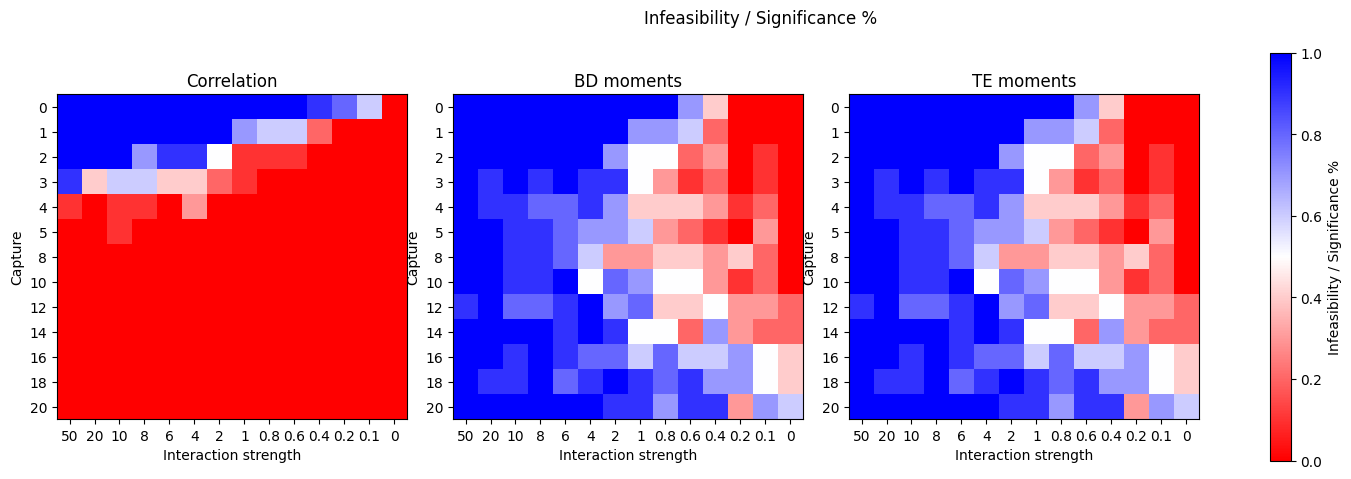

In [46]:
plot(percents_10, capture_values, interaction_values)

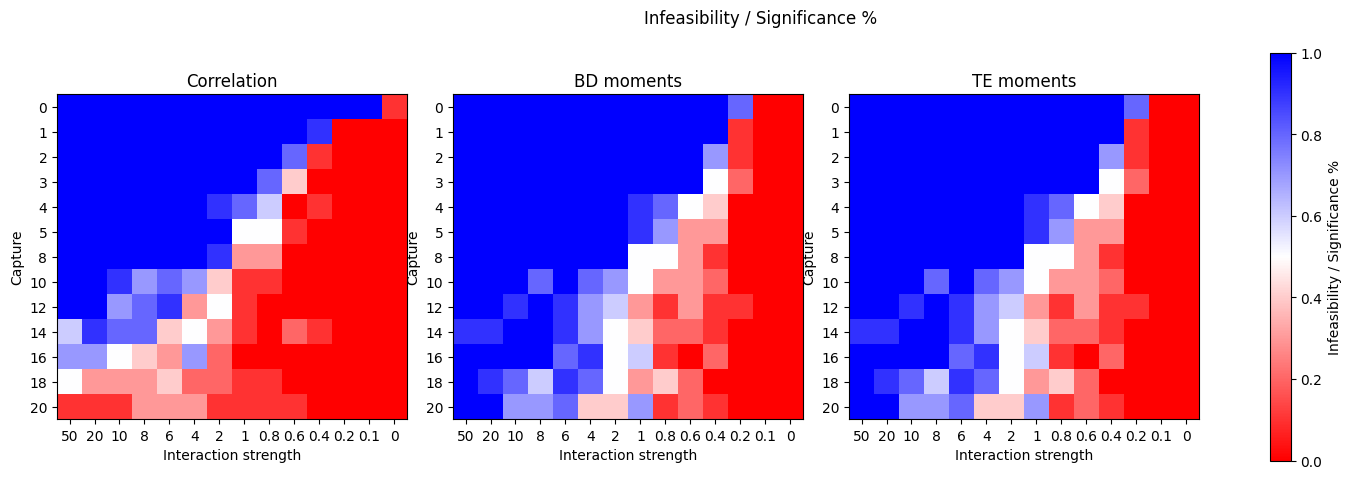

In [47]:
plot(percents_50, capture_values, interaction_values)

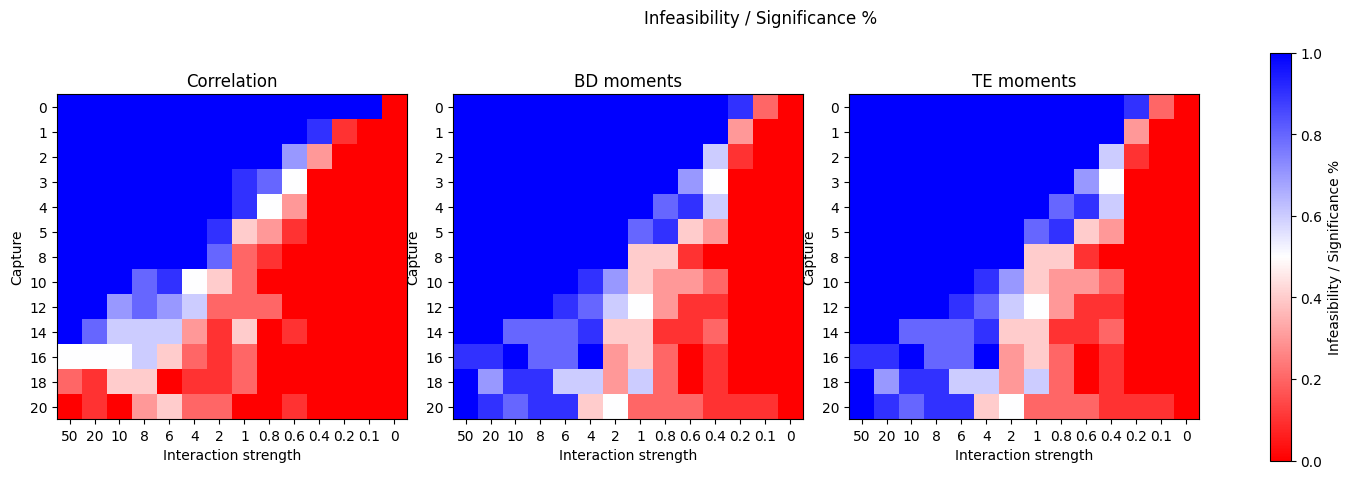

In [48]:
plot(percents_100, capture_values, interaction_values)

BUT was threshold beta because was using probs, so remove and retry (clear Temp first)